In [139]:
# Installed scikit-video (skvideo) and ffmpeg from conda
# https://anaconda.org/conda-forge/sk-video
# https://anaconda.org/conda-forge/ffmpeg

import skvideo.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
from skimage.exposure import histogram
from skimage.feature import canny
from skimage.filters import sobel, threshold_otsu, threshold_local
from skimage.segmentation import watershed

from ipywidgets import interact

# skvideo can either use vread or vreader
# vreader uses a generator (loads frames on-demand to save memory)

# If file is avi:
file_name = 'laser.mp4'
frames = skvideo.io.vread(file_name, as_grey = True)

# Check the size of the loaded data
frames.shape

(200, 500, 1024, 1)

Inspect the data and perform a background correction

In [84]:
def frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = True):
    image = frames[frame_number].squeeze() + 0.01 # Add 0.01 to avoid zero division
    background = frames[background].squeeze() + 0.01
    if takelog == True:
        image = np.log(image) - np.log(background) # Subtract background
    else:
        image = image - background
    image = image[cropv[0]:cropv[1], croph[0]:croph[1]] # Crop image if necessary
    return image

In [47]:
def frame_plotter(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None)):
    image = frame_generator(frames, frame_number, background, cropv, croph)

    # Plot the image
    fig, axes = plt.subplots(1, 1, figsize = (15,10))
    im1 = axes.imshow(image)
    fig.colorbar(im1, shrink = 0.2)
    plt.show()

Find a good background frame with interactive plot

In [48]:
@interact
def show_frame(frame_number=(0, len(frames)-1, 1), background = (0, len(frames)-1, 1)):
    frame_plotter(frames, frame_number, background=background, cropv = (None, None))


interactive(children=(IntSlider(value=99, description='frame_number', max=199), IntSlider(value=99, descriptio…

https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html reference for some of this code

Test to see if thresholding is sufficient to segment

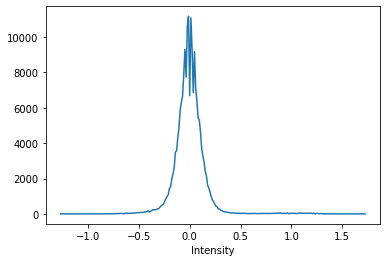

In [63]:
# Plot the intensity histogram
image = frame_generator(frames, 181, background = 19, cropv = (105, 300), croph = (None, None))
hist, hist_centers = histogram(image)
plt.plot(hist_centers, hist)
plt.xlabel('Intensity')
plt.show()

In [73]:
@interact
def thresholding(th_low = (-0.7, 0.7, 0.1), th_high = (-0.7, 0.7, 0.1)):
    markers = np.zeros_like(image)
    markers[image < th_low] = 1
    markers[image > th_high] = 2

    plt.figure(figsize = (15,10))
    plt.imshow(markers)
    plt.colorbar(shrink = 0.2)

interactive(children=(FloatSlider(value=-0.09999999999999987, description='th_low', max=0.7, min=-0.7), FloatS…

Test edge-based segmentation

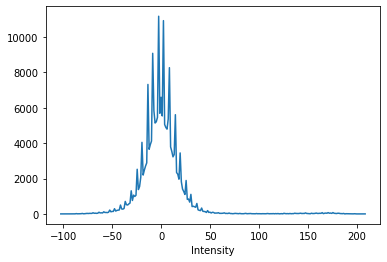

In [100]:
# Generate non-log image
image = frame_generator(frames, 181, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
# Plot the intensity histogram
hist, hist_centers = histogram(image)
plt.plot(hist_centers, hist)
plt.xlabel('Intensity')
plt.show()

In [155]:
@interact
def canny_detect(factor = (0, 1000, 1), sigma = (0,2,0.1), fill = (0, 1, 1)):
    edges = canny(image/factor, sigma = sigma)
    if fill:
        edges = ndi.binary_fill_holes(edges)
    plt.figure(figsize = (15,10))
    plt.imshow(edges)
    # plt.colorbar(shrink = 0.2)

interactive(children=(IntSlider(value=500, description='factor', max=1000), FloatSlider(value=1.0, description…

Test gradient-based segmentation
Note - there doesn't seem to be clear modality in the histogram.

In [203]:
@interact(
    frame_number = (0, len(frames)-1, 1), 
    th_low = (-70, 70, 1), 
    th_high = (-70, 70, 1), 
    segmentation = True,
    fill = True, 
    original = True,
    opacity = (0, 1, 0.1),
    remove_small = True,
    min_size = (0, 60, 1))

def manual_thresholding(
        frame_number = 181, 
        th_low = -52, 
        th_high = 12, 
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 0.3,
        remove_small = True, 
        min_size = 37):
    image = frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
    edges = sobel(image)
    markers = np.zeros_like(edges)
    markers[image < th_low] = 2
    markers[image > th_high] = 1
    out = markers
    if segmentation:
        out = watershed(edges, markers)
    if fill:
        out = ndi.binary_fill_holes(out-1)
    if remove_small:
        out = morphology.remove_small_objects(out, min_size=min_size)
    
    plt.figure(figsize = (15,10))
    if original:
        plt.imshow(image)
    plt.imshow(out, alpha = opacity)
    plt.colorbar(shrink = 0.2)
    # return out

interactive(children=(IntSlider(value=181, description='frame_number', max=199), IntSlider(value=-52, descript…

Test of local thresholding - as illumination is quite even, this doesn't give much improvement

In [144]:
@interact(
    frame_number = (0, len(frames)-1, 1), 
    block_size = (1, 99, 2),
    offset = (0, 100, 1),
    segmentation = True, 
    fill = True, 
    original = True,
    opacity = (0, 1, 0.1),
    remove_small = True,
    min_size = (0, 20, 1))

def auto_thresholding(
        frame_number = 181, 
        block_size = 31,
        offset = 10,
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 1,
        remove_small = True, 
        min_size = 10):
    image = frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
    markers = np.zeros_like(sobel(image))
    local_thresh = threshold_local(image, block_size=block_size, offset=offset)
    markers[image < local_thresh] = 2
    markers[image > local_thresh] = 1
    out = markers
    if segmentation:
        out = watershed(sobel(image), markers)
    if fill:
        out = ndi.binary_fill_holes(out-1)
    if remove_small:
        out = morphology.remove_small_objects(out, min_size=min_size)
    
    plt.figure(figsize = (15,10))
    if original:
        plt.imshow(image)
    plt.imshow(out, alpha = opacity)
    plt.colorbar(shrink = 0.2)
    # return out

interactive(children=(IntSlider(value=181, description='frame_number', max=199), IntSlider(value=31, descripti…

Generate a video of the segmented frames

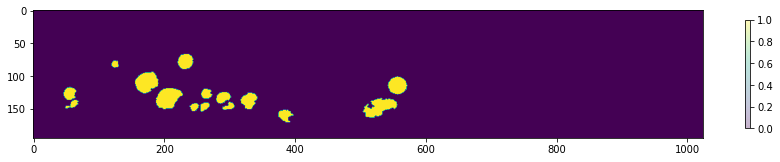

In [202]:
out = manual_thresholding(
        frame_number = 181, 
        th_low = -52, 
        th_high = 12, 
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 0.3,
        remove_small = True, 
        min_size = 37)

plt.imshow(out)

# Tracking